# Growing degree days & Extreme degree days calculations

## Packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

## Functions

In [ ]:
def growingDegreeDays(dataset_temp, corn_baseline=10):
    '''
    Calculates growing degree days, using a piecewise function
    
    inputs:
    dataset with tmax & tmin as variables as dataset_temp
    baseline temp, automatically set to 10 degrees 
    outputs:
    growing degree days for dataset
    (Haqiqi et al. 2021; D’Agostino and Schlenker, 2015)
    '''
    #gdd_ds = (dataset_temp['tmax']).copy(deep=True)
    #gdd_ds = xr.where(dataset_temp.tmin > corn_baseline)
        

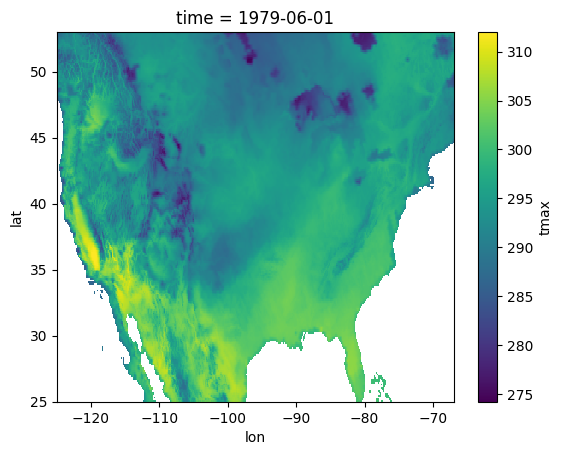

In [16]:
gdd_ds = (single_day['tmax']).copy(deep=True)
gdd_ds.plot()

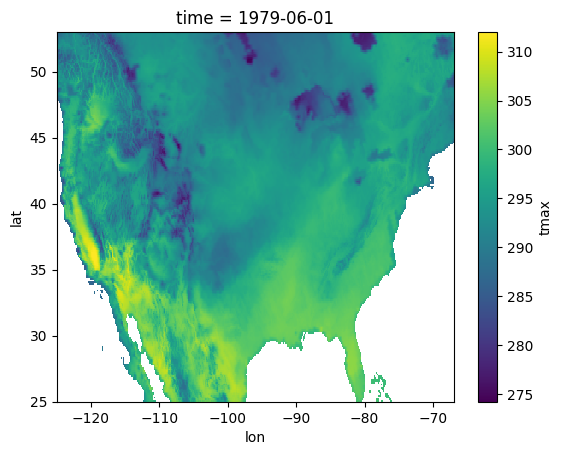

In [4]:
corn_baseline = 10
filein = "/storage/home/cta5244/work/pyWBM_yield_data/NCEPNARR_NLDAS_Hist_Temp/tmp_downloads/1979/NLDAS_FORA0125_H.A19790601.nc"
single_day = xr.open_dataset(filein)


## Calculations